# Kalman filter

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

## Overview

This lecture will cover the following topics:
- Introduction to the Kalman Filter.
- Model components and assumptions.
- The Kalman Filter algorithm.
- Application to static and dynamic one-dimensional data.
- Application to higher-dimensional data.

In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
np.random.seed(0) # for reproducibility

---

## What is a Kalman Filter?

- The Kalman Filter (KF) is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccuracies.
- It produces estimates of unknown variables that tend to be more accurate than those based only on measurements.
- Developed by Rudolf E. Kálmán in the late 1950s.
- Applications:
  - tracking objects (Apollo project, GPS, self driving cars).
  - image processing.
  - economic and financial modeling.

### Theoretical foundations

- Dynamic systems are systems that change over time.
- They are described by a set of equations that predict the future state of the system based on its current state.
- The KF assumes the system is a *linear* dynamic system with *Gaussian* noise. 
- Gaussian distributions are used because of their nice properties when dealing with averages and variances.

### What are the ingredients?

**State** 
- The true value of the variables we want to estimate. 
- The state vector represents all the information needed to describe the current state of the system.

**Observation model** 
- Relates the current state to the measurements or observations.

**Noisy measurements** 
- The process noise and measurement noise (assumed to be Gaussian) represent the uncertainty in our models and measurements. 

Example:
- Car moving at a constant velocity.
- Model: Car position = velocity $\times$ time $+$ system noise.
- Measurements: position and velocity (which are also noisy).

### The role of noise

The tradeoff between the influence of the model and the measurements is determined by noise.

- If the model has relatively large errors, more importance is given to the latest measurements in computing the current estimate.
- If the measurement have larger errors, more importance is given to the model in making the current estimate.
- Therefore, you need to estimate not only your state but also the errors (the covariance) for both the model and the measurements.
- These must be updated at each time step, too.

### Update strategy

KF is a recursive algorithm:

- Uses information from previous time step to update the estimates.
- Does not keep in memory all the data acquired so far.
- Has predictor-corrector structure:
    - Make a prediction based on the model.
    - Update the prediction with the measurements.
    - Repeat.

### Fundamental assumptions

The Kalman filter approach is based on three fundamental assumptions:

1. The system can be described or approximated by a linear model.
2. All noise (from both the system and the measurements) is white, i.e., the values are not correlated.
3. All noise is Gaussian.

#### Assumption 1: linearity

Each variable at the current time is a linear function of the variables at previous times.

- Many systems can be approximated this way.
- Linear systems are easy to analyze.
- Nonlinear systems can often be approximated by linear models around a current estimate (extended KF).

#### Assumption 2: Whiteness

The noise values are not correlated in time.

- If you know the noise at time $t$, it doesn't help you to predict the noise at future times $t+\tau$.
- White noise is a reasonable approximation of the real noise.
- The assumption makes the mathematics tractable.

> **📝 Note** White noise contains a mix of all the different frequencies at the same intensity blended together. 
>
> This is similar to how white light contains all the colors of the rainbow combined.

#### Assumption 3: Gaussian noise

At any point in time, the probability density of the noise is a Gaussian.

- System and measurement noise are often a combination of many small sources of noise. 
- The combination effect is approximately Gaussian.
- If only mean and variance are known (typical case in engineering systems), Gaussian distribution is a good choice as these two quantities completely determine the Gaussian distribution.
- Gaussian distribution have nice properties and are easy to treat mathematically.

---

## Technical details

### Combining two sources

Assume a car has a certain initial position $x_0=0$ and initial velocity $\dot{x}_0=60 km/h$.

If the speed is constant, we have:

$$x_{t} = 1\cdot x_{t-1} + \delta t \cdot \dot{x}_{t-1}$$
$$\dot{x}_{t} = 0 \cdot x_{t-1} + 1 \cdot \dot{x}_{t-1}$$

In matrix form:

$$ \boldsymbol{x}_{t} = 
\begin{bmatrix}
x_{t} \\
\dot{x}_{t}
\end{bmatrix}
=
\begin{bmatrix}
1 & \delta t \\
0 & 1 
\end{bmatrix}
\begin{bmatrix}
x_{t-1} \\
\dot{x}_{t-1}
\end{bmatrix} = \mathbf{A} \boldsymbol{x}_{t-1}
$$

<img src="media/system.png" style="width: 50%; display: block; margin: auto;">

- The current position and speed will evolve according to this simple dynamical system 

$$\boldsymbol{x}_{t} = \mathbf{A} \boldsymbol{x}_{t-1} + \boldsymbol{w}_{t-1}$$ 

- where $\boldsymbol{w}_t \sim \mathcal{N}(0,\mathbf{Q})$ represents perturbations in the underlying dynamical systems (e.g., holes on the road).
- $\boldsymbol{x}_{t} \in \mathbb{R}^{N}$ represents the state of the system.
- $\mathbf{Q} \in \mathbb{R}^{N \times N}$ is the *process noise covariance*, where $N$ represents the number of state variables (2 in our case, position and speed).

Where the car will be after 1 minute?

If we rely only on our simple sistem $\boldsymbol{x}_{t+1} = \mathbf{A} \boldsymbol{x}_{t}$ without even consider the noise, the car will keep moving at $60 km/h$ and will be at $1 km$ distance.

<img src="media/model_pred.png" style="width: 50%; display: block; margin: auto;">

Let say our car has a GPS.
- As all instruments, our GPS will be affected by errors and gives us measurements with uncertainties in it.
- In addition, our GPS can only measure the position but not the speed.
- Based on our GPS, after 1 minute we are at $0.8 km$ from where we started.

<img src="media/gps.png" style="width: 50%" align="center">

- Let the measure of our GPS be 

$$\boldsymbol{z}_t = \mathbf{H} \boldsymbol{x}_t + \boldsymbol{v}_t$$ 

- where $\boldsymbol{v}_t \sim \mathcal{N}(0,\mathbf{R})$ represents the uncertainty in the measures.
- $\boldsymbol{z}_{t} \in \mathbb{R}^{M}$ is the measurements vector.
- In our case, since the GPS measures only the position, we have $\mathbf{H} = \begin{bmatrix} 1 & 0 \end{bmatrix}$ and $\mathbf{R} = \begin{bmatrix} r_{xx} \end{bmatrix}$.
- In general, $\mathbf{H} \in \mathbb{R}^{M,N}$ is a matrix that maps the $N$ state variables into the $M$ measurements and $\mathbf{R} \in \mathbb{R}^{M,M}$ is the measurement noise covariance.

In summary, we have two different sources of information:
- a linear stochastic difference equation, representing our imprecise knowledge of a discrete-time controlled process;
- a source of measurements, that are noisy.

<img src="media/inputs.png" style="width: 20%; display: block; margin: auto;">

How do we combine them to get the best possible estimate of our system variables?

### The KF algorithm

The KF is an interative procedure that consists of two steps: 

- **Predict** (Time update)
- **Correct** (Measurement update)

These two steps are used to update two quantities:
- The **state estimate**.
- The uncertainty about our state estimate, called **covariance estimate**.

Before looking at the iterative procedure let's introduce this second quantity.

**Covariance estimate**

There are two sources of error in the estimate of the state of our system.

- The *prior* estimate error $e^{-}_t = x_t - \hat{x}^{-}_t$.
- The *posterior* estimate error $e_t = x_t - \hat{x}_t$.

Where:
- $\hat{x}^{-}_t$ is the estimate of the state based only on the knowledge of the system, e.g., the dynamics equations.
- $\hat{x}_t$ is the estimate based also on the measurement $z_t$, e.g., the GPS. 

Each type of error is associated with a covariance matrix, which reflects the amount of uncertainty in the state estimates.

- $\mathbf{P}_t^{-} = \mathbb{E}[e^{-}_t e^{-T}_t] \in \mathbb{R}^{N\times N}$ (*prior* covariance estimate).
- $\mathbf{P}_t = \mathbb{E}[e_t e^{T}_t] \in \mathbb{R}^{N\times N}$ (*posterior* covariance estimate).
- In our case, we have  $\mathbf{P}_t = \begin{bmatrix} p_{xx} & p_{\dot x x} \\ p_{\dot x x} & p_{\dot x \dot x} \end{bmatrix}$ (for readability, the index $t$ on the matrix elements is omitted):
  - $p_{xx}$ is the uncertainty about the position;
  - $p_{\dot x \dot x}$ is the uncertainty about the velocity;
  - $p_{x \dot x}$ and $p_{\dot x x}$ represent the correlation between the noise in the measurements of the position and the speed.
- $\mathbf{P}_t^{-}$ has the same form.

#### Predict

- The dynamics equations are responsible for projecting forward (in time) the current state and error covariance estimates to obtain the *prior* estimate for the next time step.
- Such time update equations can also be thought of as *predictor equations*.

State estimate update: 

$$\hat{\boldsymbol{x}}_{t}^{-} = \mathbf{A} \hat{\boldsymbol{x}}_{t-1}$$

<img src="media/model_pred.png" style="width: 50%; display: block; margin: auto;">

Covariance estimate update: 

$$
\begin{aligned} 
\mathbf{P}_{t}^{-} &= \mathbb{E}[e^{-}_t e^{-T}_t] \\
  &= \mathbb{E}[(\boldsymbol{x}_{t} - \hat{\boldsymbol{x}}^{-}_{t})(\boldsymbol{x}_{t} - \hat{\boldsymbol{x}}^{-}_{t})^T] \\
  &= \mathbb{E}[(\mathbf{A} \boldsymbol{x}_{t-1} + \boldsymbol{w} - \mathbf{A} \hat{\boldsymbol{x}}_{t-1})(\mathbf{A} \boldsymbol{x}_{t-1} + \boldsymbol{w} - \mathbf{A} \hat{\boldsymbol{x}}_{t-1})^T] \\
  &= \mathbb{E}[(\mathbf{A}e_{t-1})(e_{t-1}^T \mathbf{A}^T)] + \mathbb{E}[\boldsymbol{w}\boldsymbol{w}^T]\\
  &= \mathbf{A}\mathbb{E}[e_{t-1}e_{t-1}^T ]\mathbf{A}^T + \mathbf{Q} \\
  &= \mathbf{A}\mathbf{P}_{t-1}\mathbf{A}^T + \mathbf{Q}
\end{aligned}
$$

In summary, the Predict step consists of two equations to update:
- State estimate.
- Covariance estimate.

<img src="media/update.png" style="width: 20%; display: block; margin: auto;">

#### Correct

The measurement update equations are responsible for the feedback, i.e. for incorporating a new measurement into the prior estimate to obtain an improved posterior estimate.

The posterior estimate $\hat{\boldsymbol{x}}_{t}$ is a linear combination of:
- The prior estimate $\hat{\boldsymbol{x}}^{-}_{t}$.
- A weighted difference between the actual measurement $\boldsymbol{z}_{t}$ and a measurement prediction $\mathbf{H} \hat{\boldsymbol{x}}^{-}_{t}$.

$$\hat{\boldsymbol{x}}_{t} = \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{K}_t(\boldsymbol{z}_{t} - \mathbf{H} \hat{\boldsymbol{x}}^{-}_{t})$$

- The difference $\Delta_t = \boldsymbol{z}_{t} - \mathbf{H} \hat{\boldsymbol{x}}^{-}_{t}$ is called measurement *innovation* or *residual*.
- $\Delta_t$ reflects the difference between our imprecise prediction ($\mathbf{H} \hat{\boldsymbol{x}}^{-}_{t}$) and the actual noisy measurement ($\boldsymbol{z}_{t}$).
- A residual of zero means that the two are in complete agreement.

<img src="media/innovation.png" style="width: 50%; display: block; margin: auto;">

The matrix $\mathbf{K} \in \mathbb{R}^{N \times M}$ is chosen to be the **gain** that minimizes the posterior error covariance.

Derivation (sketch):
1. Define the posterior error  $e_t = x_t - \hat{x}_t$.
2. Define the posterior error covariance $P_t = \mathbb{E}[e_t e^{T}_t]$.
3. Substitute $\hat{\boldsymbol{x}}_{t} = \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{K}\Delta_t$ in 1).
4. Substitute the $e_t$ obtained from 3) in 2) and take the expectation.
5. Take the derivative of the trace of the result with respect to $\mathbf{K}$.
6. Set the result equal to zero.
7. Solve for $\mathbf{K}$.

The previous derivation give us the following result:

$$\mathbf{K}_t = \mathbf{P}^{-}_t \mathbf{H}^T (\mathbf{H} \mathbf{P}^{-}_t \mathbf{H}^T + \mathbf{R})^{-1}= \frac{\mathbf{P}^{-}_t \mathbf{H}^T}{\mathbf{H} \mathbf{P}^{-}_t \mathbf{H}^T + \mathbf{R}}$$

Back to our car example, we have:

$$\mathbf{K}_t = \frac{\begin{bmatrix} p^{-}_{xx} & p^{-}_{\dot x x} \\ p^{-}_{\dot x x} & p^{-}_{\dot x \dot x} \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix}}{\begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} p^{-}_{xx} & p^{-}_{\dot x x} \\ p^{-}_{\dot x x} & p^{-}_{\dot x \dot x} \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix} + \begin{bmatrix} r_{xx} \end{bmatrix}} = \frac{\begin{bmatrix} p^{-}_{xx} \\ p^{-}_{x \dot x} \end{bmatrix}}{p^{-}_{xx} + r_{xx}}$$

Once again, the index $t$ has been dropped from the elements of $\mathbf{P}^{-}_t$ for readability.

The update equations for the position and speed become:

- Position: $\hat{x}_t = \hat{x}_t^{-} + \frac{p^{-}_{xx}}{p^{-}_{xx} + r_{xx}} \Delta_t$
- Speed: $\hat{\dot x}_t = \hat{\dot x}_t^{-} + \frac{p^{-}_{x \dot x}}{p^{-}_{xx} + r_{xx}} \Delta_t$

- One key observation is that the speed is updated even if we do not have a direct measure for it in our measurement $\boldsymbol{z}_t$.
- The update is possible thanks to the term $p^{-}_{x \dot x}$ in $\mathbf{K}_t$ that relates the position (and its measurement) to the velocity.
- This showcases one of the main strengths of KF: it can handle *partial observations*.

Let's consider the two extreme cases for the values of $\mathbf{K}_t$

1. The measurement error covariance $\mathbf{R}$ approaches zero, i.e., there is no noise in the measurements.
   - The measurements are completely reliable.
   - We have $\lim \limits_{\mathbf{R} \rightarrow 0} \mathbf{K}_t = \frac{\mathbf{P}^{-}_t \mathbf{H}^T}{\mathbf{H} \mathbf{P}^{-}_t \mathbf{H}^T + \mathbf{R}} = \mathbf{H}^{-1}$
   - $\mathbf{K}$ weights the residuals more heavily: 
   
   $$
   \begin{aligned} 
   \hat{\boldsymbol{x}}_{t} &= \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{H}^{-1}\Delta_t = \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{H}^{-1}(\boldsymbol{z}_{t} - \mathbf{H} \hat{\boldsymbol{x}}^{-}_{t})\\ 
   &= \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{H}^{-1}\boldsymbol{z}_{t} - \mathbf{H}^{-1}\mathbf{H} \hat{\boldsymbol{x}}^{-}_{t} = \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{H}^{-1}\boldsymbol{z}_{t} -  \hat{\boldsymbol{x}}^{-}_{t}\\ 
   &= \mathbf{H}^{-1}\boldsymbol{z}_{t} 
   \end{aligned}
   $$

<img src="media/extreme1.png" style="width: 50%; display: block; margin: auto;">

2. The covariance estimate $\mathbf{P}^{-}_t$ approaches zero.
   - The model is completely reliable and the measurements are not accounted for.
   - We have $\lim \limits_{\mathbf{P}^{-}_t \rightarrow 0} \mathbf{K}_t = \frac{\mathbf{P}^{-}_t \mathbf{H}^T}{\mathbf{H} \mathbf{P}^{-}_t \mathbf{H}^T + \mathbf{R}} = 0$.
   - $\mathbf{K}$ does not give importance to the residuals: $\hat{\boldsymbol{x}}_{t} = \hat{\boldsymbol{x}}^{-}_{t} + 0\Delta_t = \hat{\boldsymbol{x}}^{-}_{t}$.

<img src="media/extreme2.png" style="width: 50%; display: block; margin: auto;">

- The last thing that remains to update is the posterior covariance estimate $\mathbf{P}_t$ to be used in the next predict step.
- The formula is:

$$\mathbf{P}_t = (\mathbf{I} - \mathbf{K}_t \mathbf{H})\mathbf{P}^{-}_t$$

- Let's look again at the two extreme cases:

- $\mathbf{K}_t = \mathbf{H}^{-1} \rightarrow \mathbf{P}_t = 0$
  - This is the case where the measurements are completely reliable.
  - The only source of uncertainty at the next Predict step will be the one of the model: $\mathbf{P}_t^{-} = \mathbf{A}\mathbf{P}_t\mathbf{A}^T + \mathbf{Q} = \mathbf{Q}$.

- $\mathbf{K}_t = 0 \rightarrow \mathbf{P}_t = \mathbf{P}^{-}_t$
  - This is the case where the measurements are unreliable and not accounted for.
  - The posterior covariance estimate is exactly the same as the prior covariance estimate $\mathbf{P}^{-}_t$ obtained in the Predict step using the model and not modified with the new measurements in the Correct step.

Summary of the Correct step:

<img src="media/correct.png" style="width: 25%; display: block; margin: auto;">

The whole process is summarized below.

<img src="media/kalman.png" style="width: 50%; display: block; margin: auto;">

### Parameters estimation

In general, both the measurement noise covariance $\mathbf{R}$ and the process noise covariance $\mathbf{Q}$ are **unknown**.

- Estimating $\mathbf{R}$ is usually done prior to operation of the filter. 
- Measuring $\mathbf{R}$ is usually possible because we measure the process anyway (while operating the filter).
- We can take some offline sample measurements to determine the variance of the measurement noise.

- Determining the process noise covariance $\mathbf{Q}$ is generally more difficult.
- We typically do not have the ability to directly observe the process we are estimating. 
- Sometimes a relatively simple process model can produce acceptable results if one "injects" enough uncertainty into the process. 
- This works well if the process measurements are reliable.


### Extensions and Variants
  - The Extended Kalman Filter (EKF) is used for nonlinear systems by linearizing about the current estimate.
  - The Unscented Kalman Filter (UKF) uses a deterministic sampling technique to capture the mean and variance of the state distribution.


### Practical Considerations
- Designing an accurate model and having reliable measurements are crucial for effective filtering.
- Dealing with nonlinearities can be challenging and may require the EKF or UKF.
- Tuning process and measurement noise covariances $\mathbf{Q}$ and $\mathbf{R}$ is essential for optimal performance.

---

## Python implementation

- Next, we will implement the Kalman Filter in Python and use it to estimate the value of a signal from noisy data. 
- Initially, we will construct the algorithm by hand so we understand all the steps involved. 
- Also, we will generate datasets from scratch so we know what our true result should be and therefore gain insight into how well the Kalman Filter works. 

### The algorithm 

This is the workflow of the algorithm we are going to implement:

1. Make an initial estimate of your state vector and covariance matrix.
2. Predict the state and covariance for the next time step.
3. Computer the Kalman gain.
4. Make a measurement.
5. Update estimates of state and covariance.
6. Repeat from step 2.

For one-dimensional examples, there are a couple of simplifications: 
- the state vector is a single number (a scalar).
- the covariance matrix reduces to the variance (also a scalar). 

Therefore, only normal multiplication (as opposed to matrix multiplication) is involved.

### Example 1: Static one-dimensional data

- Let's start by considering a simple example: determine the position of a stationary car. 
- We'll assume that all we are interested in is a one-dimensional value, such as the distance along a road from a landmark.
- We are going to try to predict the true position based on some noisy measurements of the distance. 
- Since we are going to generate the noisy measurements by hand, we will know the true position and we can see how well our algorithm performs. 

- We assume the measurements to follow this distribution:

$$z_t = \mu + v_t \;\; \text{with}\;\; v_t \sim \mathcal{N}(0, R)$$ 

- where $\mu$ is the actual position and $R$ is the actual measurement noise covariance.
- Note that both $\mu$ and $R$ are unknown to the filter.

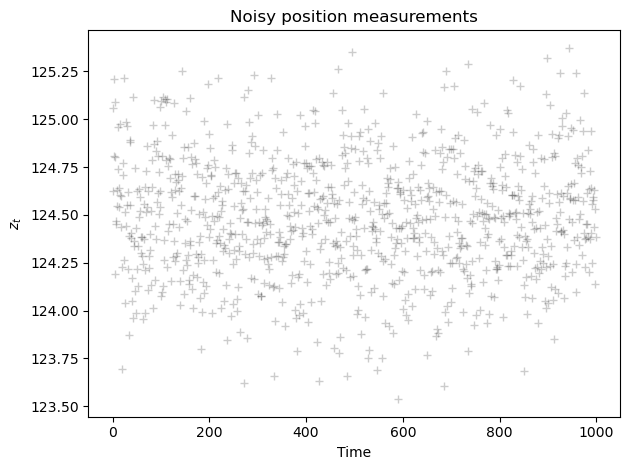

In [2]:
mu = 124.5 # Actual position
R = 0.1    # Actual standard deviation of actual measurements (R)

# Generate measurements
n_measurements = 1000 # Change the number of points to see how the convergence changes
Z = np.random.normal(mu, np.sqrt(R), size=n_measurements)

plt.plot(Z,'k+',label='measurements $z_t$',alpha=0.2)
plt.title('Noisy position measurements')
plt.xlabel('Time')
plt.ylabel('$z_t$')
plt.tight_layout();

- As discussed previously, since the actual measurement noise covariance is unknown, we have to provide an estimate.
- This is usually feasible as we can estimate $R$ from the available measurements.
- In addition, we need to estimate the process noise covariance $Q$, which is usually harder to guess.
- Remember that $Q$ represents the noise of the model used to describe the actual position.
- In our case:

$$x_t = x_0 + w_t \;\; \text{with}\;\; w_t \sim \mathcal{N}(0,Q)$$

- In summary, we have two noise parameters: one for the model ($Q$) and one for the measurement ($R$). 
- The values of $Q$ and $R$ are inputs for the algorithm.  
- Therefore, since we usually don't $Q$ and $R$, we have to make reasonable estimates. 

- In this example, we know the actual variance for the measurements (since we are generating the measurements ourselves).
- We can see the effect of making a good or a bad estimate for this parameter. 
- Also, we choose the actual position of our car, so we can see how quickly the KF converges to the true value.
- Finally, we need to guess initial values for the initial position of the car and the variance in this initial estimate. 

In [3]:
# Estimated covariances
Q_est = 1e-4 
R_est = 2e-2 

- Create a function that computes the estimated position and associated error using the KF.

In [4]:
def kalman_1d(x, P, measurement, R_est, Q_est):
    
    # Prediction
    x_pred = x
    P_pred = P + Q_est

    # Update
    K = P_pred / (P_pred + R_est)
    x_est = x_pred + K * (measurement - x_pred)
    P_est = (1 - K) * P_pred

    return x_est, P_est

- Apply the filter to the 1D static measurements.

In [5]:
# initial guesses 
x = 123 # Use an integer (imagine the initial guess is determined with a meter stick)
P = 0.04 # error covariance P

KF_estimate=[] # To store the position estimate at each time point 
KF_error=[] # To store estimated error at each time point
for z in Z:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

- Now, plot an estimate for the value $x_t$ on top of the measurements $z_t$. 
- We also plot how the covariance estimate $P_t$ changes during the process. 

In [6]:
def plot_1d_comparison(measurements_made, estimate, true_value, axis):
    axis.plot(measurements_made,'k+',label='measurements',alpha=0.3)
    axis.plot(estimate,'-',label='KF estimate')
    if not isinstance(true_value, (list, tuple, np.ndarray)):
        # plot line for a constant value
        axis.axhline(true_value,color='r',label='true value', alpha=0.5) 
    else:
        # for a list, tuple or array, plot the points
        axis.plot(true_value,color='r',label='true value', alpha=0.5)
    axis.legend(loc = 'lower right')
    axis.set_title('Estimated position vs. time step')
    axis.set_xlabel('Time')
    axis.set_ylabel('$x_t$')
    
def plot_1d_error(estimated_error, lower_limit, upper_limit, axis):
    # lower_limit and upper_limit are the lower and upper limits of the vertical axis 
    axis.plot(estimated_error, label='KF estimate for $P$')
    axis.legend(loc = 'upper right')
    axis.set_title('Estimated error vs. time step')
    axis.set_xlabel('Time')
    axis.set_ylabel('$P_t$')
    plt.setp(axis,'ylim',[lower_limit, upper_limit])

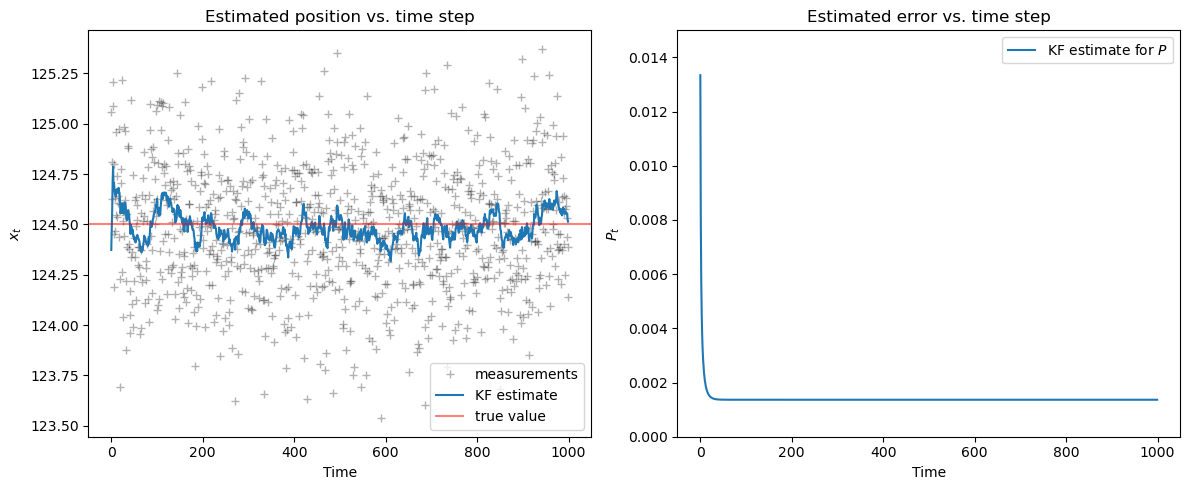

In [7]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Z, KF_estimate, mu, axes[0])
plot_1d_error(KF_error, 0, 0.015, axes[1])
plt.tight_layout();

- We see that for the parameters we've chosen, the filter converges to the true value quickly and the noise is filtered out. 

**Question:** How much the KF estimate fluctuates around the true value? 

**Answer:** The fluctuations around the true value are approximately the size of the standard deviation of the estimate, which is $\sqrt{P_t}$.

### Example 2: Dynamic one-dimensional data

- Let's now consider the system we saw earlier, a car that moves approximately at a constant velocity $v_0$.
- The position changes over time according to the following formula:

$$x_{t} = x_{t-1} + \delta t \cdot v_0 + w_t$$ 

- where $w_t \sim \mathcal{N}(0, Q)$ represents the model noise.

- Now, assume we have measurements only for the position, but not the velocity.
- Let the measurements be generated according to the following distribution:

$$z_t = z_{t-1} + \delta t \cdot v_t$$

- In this case, $v_t$ represent a noisy measurement for the velocity, that is not observed directly.
- We let $v_t \sim \mathcal{N}(v_0, R)$, where $R$ represents the variance of the measurements error.

- Let's now modify our static algorithm to take into account this motion. 
- At each time point, we will generate a random value $v_t$ for the velocity measurement. 
- We will assume that the car moves at velocity $v_t$ until the next time point, which allows us to calculate the distance traveled. 
- By summing all of the distances traveled, we can calculate the measured position of the car $z_t$.
- Then we will apply the KF and compare the KF estimate for the position with both the actual position $x_t = x_0 + v_0 \cdot t$ and the measured positions $z_t$.

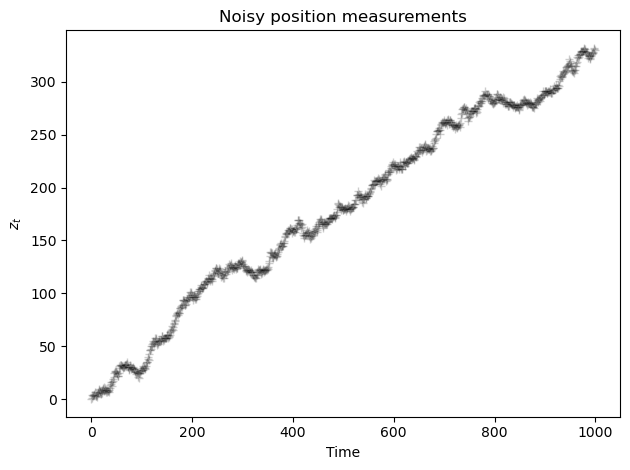

In [8]:
# initial parameters
v0 = 0.3 
x0 = 0.0     
R = 4.0

# generate noisy measurements
n_measurements = 1000
Zv = np.zeros(n_measurements) # velocity measurements
Zx = np.zeros(n_measurements) # position measurements
for t in range(0, n_measurements-1):
    Zv[t] = np.random.normal(v0, np.sqrt(R)) 
    Zx[t+1] = Zx[t] + Zv[t] * 1 # delta_t = 1

# generate true positions
Xt = np.zeros(n_measurements) 
for t in range(0, n_measurements):
    Xt[t]= x0 + v0*t

plt.plot(Zx,'k+',label='measurements $z_t$',alpha=0.2)
plt.title('Noisy position measurements')
plt.xlabel('Time')
plt.ylabel('$z_t$')
plt.tight_layout();

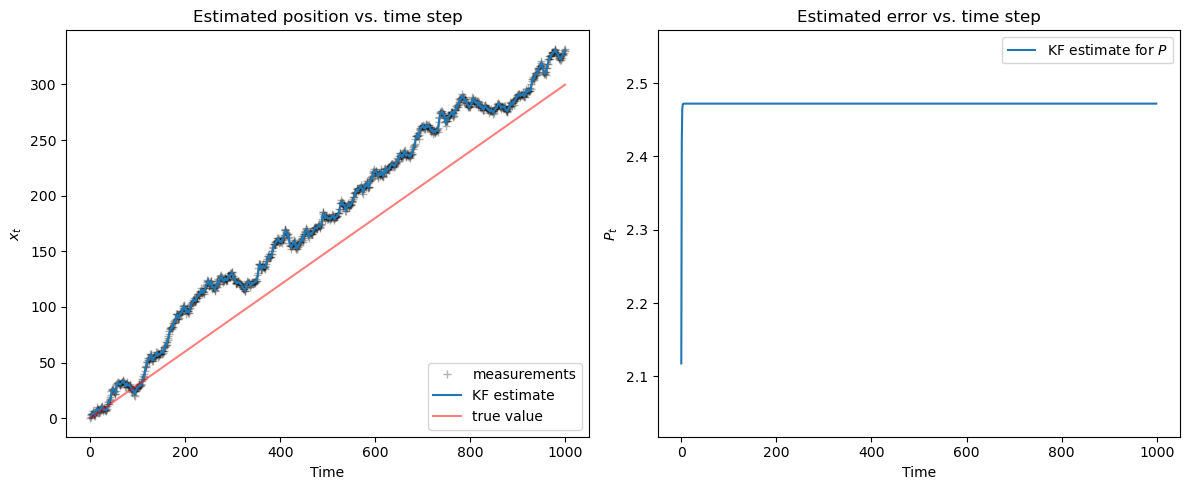

In [9]:
# initial guesses and estimates
x = 0 
P = 0.5
Q_est = 4 
R_est = 4
KF_estimate = [] # To store the position estimate at each time point 
KF_error = [] # To store estimated error at each time point

# Kalman filter
for z in Zx:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Zx, KF_estimate, Xt, axes[0])
plot_1d_error(KF_error, min(KF_error)-0.1, max(KF_error)+0.1, axes[1])
plt.tight_layout();

**Question:** Neither the measurements nor the KF estimate are close to the true value. Why?

**Answer:** The measurements are not close to the true value because the variance of the measurements error $R$ is large compared to the velocity $v_0$. 

- The KF estimate is tracking the measurements, so it won't be close to the true value. 
- In addition, we do not have measurements for the instant velocity.

- With dynamic models, there are more parameters to tune, so it can be more challenging to reach convergence. 
- If we had a way to measure velocity, we could use that information too. 
- Nevertheless, the KF can work with incomplete observations, which is one of its main advantages. 

### Example 3: Dynamic two-dimensional data

- Now we consider an example that is closer to real-world applications: estimating the motion of a point in two dimensions, $x$ and $y$. 
- This 2D algorithm is used in mouse tracking software and also to track objects in videos. 
- As before, we will use instantaneous measurements for the position ($x, y$).
- We are going to use the Kalman filter built into OpenCV. 

Our system is defined by the following quantities:

- State vector $\boldsymbol{x} = \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \end{bmatrix}$, representing the 2D position and 2D velocity.
- Measurement vector $\boldsymbol{z} = \begin{bmatrix} z_x \\ z_y  \end{bmatrix}$, representing measurements for the 2D position.
- Transition matrix $\mathbf{A} = \begin{bmatrix} 1 & 0 & \delta_t & 0 \\ 0 & 1 & 0 & \delta_t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$ (called `transitionMatrix` in OpenCV).
- Measurement matrix $\mathbf{H} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}$ (called `measurementMatrix` in OpenCV).

- The covariance of the model noise $\mathbf{Q} = \begin{bmatrix}  q & 0 & 0 & 0 \\  0 & q & 0 & 0 \\ 0 & 0 & q & 0 \\ 0 & 0 & 0 & q  \end{bmatrix}$ (called `processNoiseCov` in OpenCV).
- The covariance of the measurements noise $\mathbf{R} = \begin{bmatrix}  r & 0 \\ 0 & r  \end{bmatrix}$ (called `measurementNoiseCov` in OpenCV).

For simplicity, we use diagonal covariances in this example.

The constructor has has the following sintax:

> `KalmanFilter(state_size, measurements_size, control_size)`

where:
- `state_size` is the dimension of the state vector $\boldsymbol{x}$, which is 4 in our case.
- `measurements_size` is the dimension of the state vector $\boldsymbol{x}$, which is 2 in our case.
- `control_size`, which is 0 since we do not have the optional control $\boldsymbol{u}$ (not discussed in this lecture).

In [10]:
kalman = cv2.KalmanFilter(4,2,0) # 4 states, 2 measurements, 0 control vector

q = 1 # the variance in the model
r = 20 # the variance in the measurement
dtime = 1 # size of time step

kalman.measurementMatrix = np.array([[1,0,0,0],
                                     [0,1,0,0]],np.float32) #  H
kalman.transitionMatrix = np.array([[1,0,dtime,0],
                                    [0,1,0,dtime],
                                    [0,0,1,0],
                                    [0,0,0,1]],np.float32) # A
kalman.processNoiseCov = np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0],
                                   [0,0,0,1]],np.float32) * q # Q
kalman.measurementNoiseCov = np.array([[1,0],
                                       [0,1]],np.float32) * r # R

KF_estimate_xy = [] # To store the position estimate at each time point

- Next, we will load some pre-computed data.

In [ ]:
xy_motion = pd.read_csv('https://zenodo.org/records/10951538/files/kf_ts1.csv?download=1',
                        header = None).values.astype('float32')

- Here, we use pre-computed data for simplicity/reproducibility.
- However, you can generate your own $(z_x, z_y)$ measurements by clicking first on the grid and then on ``Generate Sample``.

In [11]:
from IPython.display import IFrame
IFrame('https://guoguibing.github.io/librec/datagen.html', width=900, height=800)

- As always, take a look at the data before analyzing it. 
- Also, it is good practice to make sure the data loaded properly.

In [13]:
print(len(xy_motion))
print(xy_motion[0:10]) # Print first 10 items for clarity, but can look at all 205 or plot them

205
[[2.35 1.45]
 [3.55 1.8 ]
 [3.   2.9 ]
 [2.65 4.2 ]
 [2.95 5.15]
 [3.7  5.4 ]
 [4.8  5.55]
 [5.3  5.25]
 [5.7  5.25]
 [5.8  5.85]]


- We are now ready to apply the KF. 
- In the OpenCV implementation of the KF there is no initialization options. 
- Both the state vector $\boldsymbol{x}$ and the covariance matrix $\mathbf{P}$ are always initialized to zero.

In [14]:
for i in xy_motion:
    pred = kalman.predict()  # predicts new state using the model
    kalman.correct((i))      # updates estimated state with the measurement
    KF_estimate_xy.append(((pred[0]),(pred[1]))) # store the estimated position

In [15]:
# Quick check: estimate has same length as measurement data
print(len(KF_estimate_xy))

205


Now plot the data and the KF estimate.

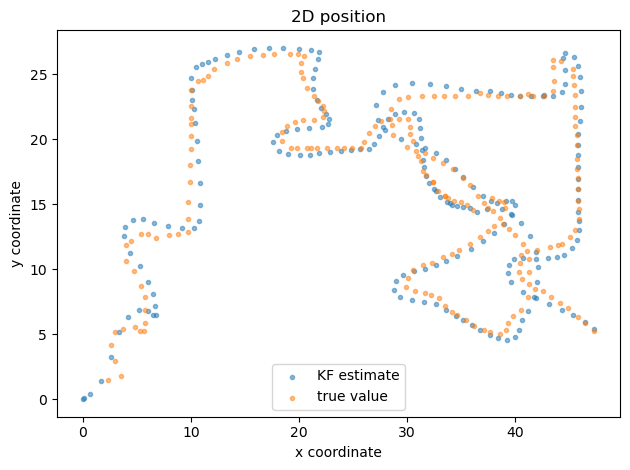

In [16]:
x_est, y_est = zip(*KF_estimate_xy)
x_true, y_true = zip(*xy_motion)
plt.scatter(x_est, y_est, marker= '.', label = 'KF estimate', alpha = 0.5)
plt.scatter(x_true, y_true,marker= '.', label = 'true value', alpha = 0.5)
plt.legend(loc = 'lower center')
plt.title('2D position')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.tight_layout();

- Pretty good agreement. 
- Once again, you are encouraged to change the parameters and explore what happens.

---

## Summary

What we covered in this lecture:

1. What is the Kalman Filter
2. The recursive formulation used to update the predictions.
3. The importance of tuning the parameters of the Kalman Filter.
4. How to apply the Kalman Filter in various situations.

---

## Exercises

### Exercise #1
This exercise refers to [Example 1](#example-1-static-one-dimensional-data).
1. Choose a value for the estimated model variance `Q_est` that is larger than estimated measurement variance `R_est`.
2. Repeat the analysis of Example 1 for this new value. 
3. Does the KF estimate converge?
4. Why the estimates changed? Do they look more noisy than before? Why?

### Exercise #2

This exercise refers to [Example 2](#example-2-dynamic-one-dimensional-data). 

In the case we examined above, the KF estimate was close to the measurements and both were different from the true value.
Change the parameters of the algorithm until you find some combinations that achieve the following:

1. Measurements, KF estimate and true value are all close.
2. Measurements, KF estimate and true value are all noticeably different.
3. The measurements are close to the true value, but the KF estimate is different.

Discuss your findings.

### Exercise #3

This exercise refers to [Example 3](#example-3-dynamic-two-dimensional-data). 

In the original example, we used both Position and Velocity (PV model) in the state vector, i.e., $\boldsymbol{x} = \begin{bmatrix} x & y & \dot x & \dot y \end{bmatrix}^T$. 

What happens if we use only the Position (P model) to describe the state? After all, our measurements only provide position. Do we really need to include the velocity?

1. Rewrite the algorithm above for the P model. 

**💡 Hint:** what is the size of the state vector in this case? What are the dimensions of the matrices that characterize the system?